# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra, Mihir Suvarna, Daniel Sialm

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Due to the increasing importance of the task of text recognition, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Dataset

In [2]:
letter_to_label = dict()
classes_collected = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes_collected)):
    letter_to_label[classes_collected[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [3]:
import os
import shutil
import glob

from PIL import Image
import torchvision.transforms as transforms

src_dir = 'dataset'
transform = transforms.ToTensor()

files_train = []
files_val = []
files_test = []
for i in range(0,16): files_train.append('P' + str(i))
for i in range(16,21): files_val.append('P' + str(i))
for i in range(21,24): files_test.append('P' + str(i))

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    file = ftitle.split("_")[0].split("-")[0]
    im = Image.open(f).convert('L')

    if file in files_train:
        imgs_train.append(transform(im).detach().numpy())
        labels_train.append(letter_to_label[letter])
    elif file in files_val:
        imgs_val.append(transform(im).detach().numpy())
        labels_val.append(letter_to_label[letter])
    elif file in files_test:
        imgs_test.append(transform(im).detach().numpy())
        labels_test.append(letter_to_label[letter])
    
data_train = torch.tensor(imgs_train)
data_val = torch.tensor(imgs_val)
data_test = torch.tensor(imgs_test)
labels_train = torch.tensor(np.array(labels_train))
labels_val = torch.tensor(np.array(labels_val))
labels_test = torch.tensor(np.array(labels_test))

print(data_train.shape, data_val.shape, data_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

torch.Size([4160, 1, 28, 28]) torch.Size([1300, 1, 28, 28]) torch.Size([780, 1, 28, 28])
torch.Size([4160]) torch.Size([1300]) torch.Size([780])


/var/folders/k7/zz5h09l90lz91rrnxkcsyfv00000gn/T/ipykernel_93592/2075399133.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/torch/csrc/utils/tensor_new.cpp:201.)
  data_train = torch.tensor(imgs_train)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: m


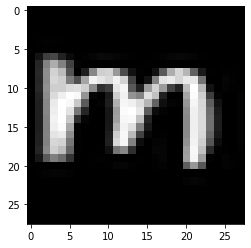

In [4]:
# Data visualization

# print classes
print(classes_collected)
# print label
index = 125
plt.imshow(data_train[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels_train[index].item()])

In [5]:
batch_size = 64

train_set_collected = torch.utils.data.TensorDataset(data_train, labels_train)
val_set_collected = torch.utils.data.TensorDataset(data_val, labels_val)
test_set_collected = torch.utils.data.TensorDataset(data_test, labels_test)

train_loader_collected = torch.utils.data.DataLoader(train_set_collected, batch_size=batch_size, shuffle=True)
val_loader_collected = torch.utils.data.DataLoader(val_set_collected, batch_size=batch_size, shuffle=True)
test_loader_collected = torch.utils.data.DataLoader(test_set_collected, batch_size=batch_size, shuffle=True)

## Defining a basic LetterCNN

In [6]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [7]:
# Testing the model above, TODO remove before submission
model_test = letterCNN(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


## Testing the basic LetterCNN

In [8]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Architecture to train and test our differnt models

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                labels = labels.type(torch.long)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    labels = labels.type(torch.long)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model.forward(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

def display_contingency_matrix(num_classes, pred, true):
    contingency = np.zeros((num_classes, num_classes))
    for i in range(len(pred)):
        contingency[int(pred[i])][int(true[i])] += 1

    plt.matshow(contingency)
    plt.xlabel("true")
    plt.ylabel("predictions")
    plt.colorbar()

In [9]:
basic_model = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=1e-3)
train_network(basic_model, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.39954
   Val loss: 2.19297

EPOCH 1
 Train loss: 1.01926
   Val loss: 2.13553

EPOCH 2
 Train loss: 0.58339
   Val loss: 2.23987

EPOCH 3
 Train loss: 0.36621
   Val loss: 2.37830

EPOCH 4
 Train loss: 0.23188
   Val loss: 2.65089

EPOCH 5
 Train loss: 0.14913
   Val loss: 2.75879

EPOCH 6
 Train loss: 0.10315
   Val loss: 2.96026

EPOCH 7
 Train loss: 0.07067
   Val loss: 3.10044

EPOCH 8
 Train loss: 0.05249
   Val loss: 3.23439

EPOCH 9
 Train loss: 0.04013
   Val loss: 3.32404



Test accuracy: 44.872


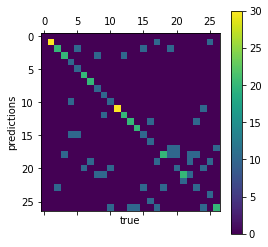

In [10]:
acc, true, pred = test_network(basic_model, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model.classes), pred, true)

We can see that there is quite a bit of overfitting going on (val loss is not converging). Also, our accuracy is quite low. While this accuracy is still quite good - $48.718 / (1 / 26) = 12.67$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained which. This ends up heavily overrepresenting our training dataset towards the handwriting of a few people. Consequently, our model does not generalize well. We can also see this from the increasing validation loss. 

Thus, we will combine our dataset with the EMNIST dataset to create a better model.

### EMNIST Data Set

In [11]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.78*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [13]:
# initialize the data sets
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


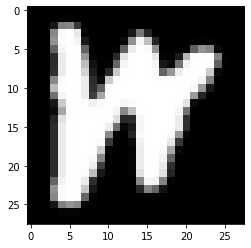

In [14]:
# Visualizing EMNIST

# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

### Combining EMNIST with our Data

In [15]:
combined_batch_size=64

combined_train = []
combined_train_labels = []
combined_val = []
combined_val_labels = []
combined_test = []
combined_test_labels = []

for inputs, labels in train_loader:
    combined_train.append(inputs[0].detach().transpose(1, 2).numpy())
    combined_train_labels.append( labels[0].item() )
for inputs, labels in train_loader_collected:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
        
for inputs, labels in val_loader:
    combined_val.append( inputs[0].detach().transpose(1, 2).numpy() )
    combined_val_labels.append( labels[0].item() )
for inputs, labels in val_loader_collected:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
        
for inputs, labels in test_loader:
    combined_test.append( inputs[0].detach().transpose(1, 2).numpy() )
    combined_test_labels.append( labels[0].item() )
for inputs, labels in test_loader_collected:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )

combined_train = np.array(combined_train)
combined_train_labels = np.array(combined_train_labels)
combined_val = np.array(combined_val)
combined_val_labels = np.array(combined_val_labels)
combined_test = np.array(combined_test)
combined_test_labels = np.array(combined_test_labels)

# print(combined_train.shape)
# print(combined_train_labels.shape)
# print(combined_val.shape)
# print(combined_val_labels.shape)
# print(combined_test.shape)
# print(combined_test_labels.shape)

combined_train = torch.Tensor(combined_train)
combined_train_labels = torch.Tensor(combined_train_labels)

combined_val = torch.Tensor(combined_val)
combined_val_labels = torch.Tensor(combined_val_labels)

combined_test = torch.Tensor(combined_test)
combined_test_labels = torch.Tensor(combined_test_labels)


combined_train_set = torch.utils.data.TensorDataset(combined_train, combined_train_labels)
combined_train_loader = torch.utils.data.DataLoader(combined_train_set, batch_size=combined_batch_size, shuffle=True)

combined_val_set = torch.utils.data.TensorDataset(combined_val, combined_val_labels)
combined_val_loader = torch.utils.data.DataLoader(combined_val_set, batch_size=combined_batch_size, shuffle=True)

combined_test_set = torch.utils.data.TensorDataset(combined_test, combined_test_labels)
combined_test_loader = torch.utils.data.DataLoader(combined_test_set, batch_size=combined_batch_size, shuffle=True)

# print(len(combined_train_loader))
# print(len(combined_val_loader))
# print(len(combined_test_loader))

EMNIST: min: 0, max: 1
Label: l


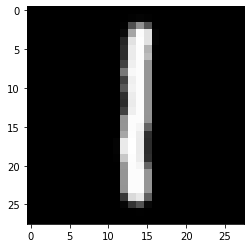

In [16]:
# Have to transpose EMNIST data (testing transpose, TODO remove before submission
for inputs, labels in train_loader:
    transposed = inputs[0].transpose(1, 2)
    print("EMNIST: min: %d, max: %d" % (transposed.min().item(), transposed.max().item()))
    plt.imshow(transposed.reshape((28, 28)), cmap='Greys_r')
    print("Label: %s" % classes_collected[labels[0]])
    break

EMNIST: min: 0, max: 1
Label: w


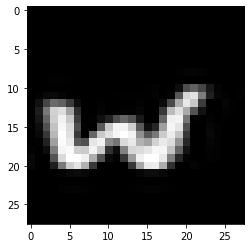

In [17]:
# validate that our two classes are being stored the same way
for inputs, labels in train_loader_collected:
    img = inputs[0]
    print("Collected: min: %d, max: %d" % (img.min().item(), img.max().item()))
    plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
    print("Label: %s" % classes_collected[labels[0]])
    break

## Making a new LetterCNN on the Combined Dataset

In [18]:
basic_model_combined = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model_combined.parameters(), lr=1e-3)
train_network(basic_model_combined, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.24138
   Val loss: 0.93942

EPOCH 1
 Train loss: 0.72009
   Val loss: 0.75933

EPOCH 2
 Train loss: 0.57530
   Val loss: 0.68050

EPOCH 3
 Train loss: 0.50422
   Val loss: 0.64345

EPOCH 4
 Train loss: 0.46033
   Val loss: 0.62435

EPOCH 5
 Train loss: 0.42778
   Val loss: 0.63305

EPOCH 6
 Train loss: 0.40244
   Val loss: 0.63349

EPOCH 7
 Train loss: 0.38319
   Val loss: 0.61634

EPOCH 8
 Train loss: 0.36935
   Val loss: 0.61540

EPOCH 9
 Train loss: 0.35337
   Val loss: 0.64287



Test accuracy: 84.736


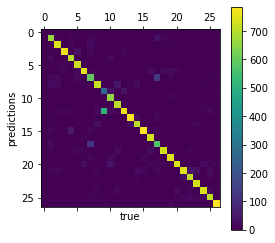

In [19]:
acc, true, pred = test_network(basic_model_combined, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model_combined.classes), pred, true)

Much higher accuracy. __TODO Explain more__

## Computational Experiment 1 - Regularization

### 1a) Regularization through data augmentation

In [20]:
src_dir = "dataset_digital"
idx = 0

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    im = Image.open(f).convert('L')

    if idx < 1820:
        imgs_train.append(transform(im).detach().numpy())
        labels_train.append(letter_to_label[letter])
    elif idx < 2210:
        imgs_val.append(transform(im).detach().numpy())
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test.append(transform(im).detach().numpy())
        labels_test.append(letter_to_label[letter])
    
    idx += 1
        
data_train = torch.tensor(imgs_train)
data_val = torch.tensor(imgs_val)
data_test = torch.tensor(imgs_test)
labels_train = torch.tensor(np.array(labels_train))
labels_val = torch.tensor(np.array(labels_val))
labels_test = torch.tensor(np.array(labels_test))

print(data_train.shape, data_val.shape, data_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

torch.Size([1820, 1, 28, 28]) torch.Size([390, 1, 28, 28]) torch.Size([468, 1, 28, 28])
torch.Size([1820]) torch.Size([390]) torch.Size([468])


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: q


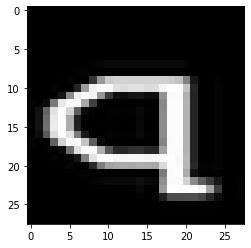

In [21]:
# Data visualization

# print classes
print(classes_collected)
# print label
index = 125
plt.imshow(data_train[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels_train[index].item()])

In [22]:
batch_size = 64

train_set_digital = torch.utils.data.TensorDataset(data_train, labels_train)
val_set_digital = torch.utils.data.TensorDataset(data_val, labels_val)
test_set_digital = torch.utils.data.TensorDataset(data_test, labels_test)

train_loader_digital = torch.utils.data.DataLoader(train_set_digital, batch_size=batch_size, shuffle=True)
val_loader_digital = torch.utils.data.DataLoader(val_set_digital, batch_size=batch_size, shuffle=True)
test_loader_digital = torch.utils.data.DataLoader(test_set_digital, batch_size=batch_size, shuffle=True)

In [23]:
combined_batch_size=64

combined_train = []
combined_train_labels = []
combined_val = []
combined_val_labels = []
combined_test = []
combined_test_labels = []

for inputs, labels in combined_train_loader:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
for inputs, labels in train_loader_digital:
    for i in range(inputs.shape[0]):
        combined_train.append( inputs[i].detach().numpy() )
        combined_train_labels.append( labels[i].item() )
        
for inputs, labels in combined_val_loader:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
for inputs, labels in val_loader_digital:
    for i in range(inputs.shape[0]):
        combined_val.append( inputs[i].detach().numpy() )
        combined_val_labels.append( labels[i].item() )
        
for inputs, labels in combined_test_loader:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )
for inputs, labels in test_loader_digital:
    for i in range(inputs.shape[0]):
        combined_test.append( inputs[i].detach().numpy() )
        combined_test_labels.append( labels[i].item() )

combined_train = np.array(combined_train)
combined_train_labels = np.array(combined_train_labels)
combined_val = np.array(combined_val)
combined_val_labels = np.array(combined_val_labels)
combined_test = np.array(combined_test)
combined_test_labels = np.array(combined_test_labels)

# print(combined_train.shape)
# print(combined_train_labels.shape)
# print(combined_val.shape)
# print(combined_val_labels.shape)
# print(combined_test.shape)
# print(combined_test_labels.shape)

combined_train = torch.Tensor(combined_train)
combined_train_labels = torch.Tensor(combined_train_labels)

combined_val = torch.Tensor(combined_val)
combined_val_labels = torch.Tensor(combined_val_labels)

combined_test = torch.Tensor(combined_test)
combined_test_labels = torch.Tensor(combined_test_labels)

combined_train_set = torch.utils.data.TensorDataset(combined_train, combined_train_labels)
combined_train_digital_loader = torch.utils.data.DataLoader(combined_train_set, batch_size=combined_batch_size, shuffle=True)

combined_val_set = torch.utils.data.TensorDataset(combined_val, combined_val_labels)
combined_val_digital_loader = torch.utils.data.DataLoader(combined_val_set, batch_size=combined_batch_size, shuffle=True)

combined_test_set = torch.utils.data.TensorDataset(combined_test, combined_test_labels)
combined_test_digital_loader = torch.utils.data.DataLoader(combined_test_set, batch_size=combined_batch_size, shuffle=True)

# print(len(combined_train_digital_loader))
# print(len(combined_val_digital_loader))
# print(len(combined_test_digital_loader))

In [24]:
model_digital = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digital.parameters(), lr=1e-3)
train_network(model_digital, combined_train_digital_loader, combined_val_digital_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.13593
   Val loss: 0.81406

EPOCH 1
 Train loss: 0.61108
   Val loss: 0.64467

EPOCH 2
 Train loss: 0.48896
   Val loss: 0.60912

EPOCH 3
 Train loss: 0.42616
   Val loss: 0.57499

EPOCH 4
 Train loss: 0.38748
   Val loss: 0.55995

EPOCH 5
 Train loss: 0.35897
   Val loss: 0.55882

EPOCH 6
 Train loss: 0.33605
   Val loss: 0.56426

EPOCH 7
 Train loss: 0.32157
   Val loss: 0.57690

EPOCH 8
 Train loss: 0.30568
   Val loss: 0.56547

EPOCH 9
 Train loss: 0.29377
   Val loss: 0.56772



Test accuracy: 86.634


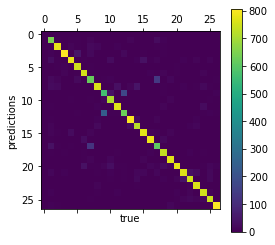

In [25]:
acc, true, pred = test_network(model_digital, combined_test_digital_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_digital.classes), pred, true)

### 1b) Regularization through dropout

In [26]:
class letterCNNDropout(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [27]:
# Testing the model above, TODO remove before submission
model_test = letterCNNDropout(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


In [28]:
model_dropout = letterCNNDropout(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)
train_network(model_dropout, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.22635
   Val loss: 0.98114

EPOCH 1
 Train loss: 0.76030
   Val loss: 0.78771

EPOCH 2
 Train loss: 0.62370
   Val loss: 0.72922

EPOCH 3
 Train loss: 0.56049
   Val loss: 0.69054

EPOCH 4
 Train loss: 0.51387
   Val loss: 0.67230

EPOCH 5
 Train loss: 0.48740
   Val loss: 0.65866

EPOCH 6
 Train loss: 0.46033
   Val loss: 0.66733

EPOCH 7
 Train loss: 0.44231
   Val loss: 0.65060

EPOCH 8
 Train loss: 0.42749
   Val loss: 0.64906

EPOCH 9
 Train loss: 0.41261
   Val loss: 0.64148



Test accuracy: 84.435


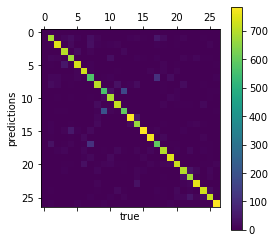

In [29]:
acc, true, pred = test_network(model_dropout, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_dropout.classes), pred, true)

### 1c) Regularization through Average Pooling

In [30]:
class letterCNNAvgPool(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [31]:
# Testing the model above, TODO remove before submission
model_test = letterCNNAvgPool(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


In [32]:
model_avgpool = letterCNNAvgPool(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_avgpool.parameters(), lr=1e-3)
train_network(model_avgpool, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.27726
   Val loss: 1.01340

EPOCH 1
 Train loss: 0.76268
   Val loss: 0.79416

EPOCH 2
 Train loss: 0.59742
   Val loss: 0.71204

EPOCH 3
 Train loss: 0.51837
   Val loss: 0.67658

EPOCH 4
 Train loss: 0.47022
   Val loss: 0.66399

EPOCH 5
 Train loss: 0.43440
   Val loss: 0.65566

EPOCH 6
 Train loss: 0.40994
   Val loss: 0.63990

EPOCH 7
 Train loss: 0.38828
   Val loss: 0.65226

EPOCH 8
 Train loss: 0.37107
   Val loss: 0.65710

EPOCH 9
 Train loss: 0.35629
   Val loss: 0.66257



Test accuracy: 84.532


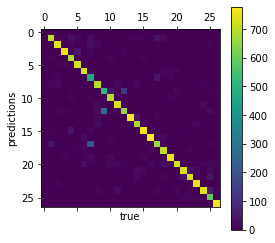

In [33]:
acc, true, pred = test_network(model_avgpool, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_avgpool.classes), pred, true)

### 1d) Regularization through Early Stopping

In [34]:
def train_network_early_stopping(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    prev_val_losses = [0] * 5
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                labels = labels.type(torch.long)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    labels = labels.type(torch.long)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                prev_val_losses[epoch % 5] = total_loss/count
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            if epoch > 5:
                prev_error_mean = sum(prev_val_losses) / len(prev_val_losses)
                if prev_error_mean > 0.80:
                    # implementing early stopping for regularization
                    # note that 0.65 here is a hyperparameter
                    print('Early stopping in epoch ' + str(epoch) + ' because the average of last 5 validation error was ' + str(prev_error_mean))
                    break
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

In [35]:
model_early_stopping = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_early_stopping.parameters(), lr=1e-3)
train_network_early_stopping(model_early_stopping, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=50)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.22933
   Val loss: 0.90086

EPOCH 1
 Train loss: 0.66729
   Val loss: 0.69901

EPOCH 2
 Train loss: 0.51694
   Val loss: 0.62772

EPOCH 3
 Train loss: 0.44670
   Val loss: 0.60421

EPOCH 4
 Train loss: 0.40125
   Val loss: 0.58846

EPOCH 5
 Train loss: 0.37142
   Val loss: 0.59959

EPOCH 6
 Train loss: 0.34662
   Val loss: 0.58308

EPOCH 7
 Train loss: 0.32625
   Val loss: 0.59262

EPOCH 8
 Train loss: 0.31220
   Val loss: 0.59123

EPOCH 9
 Train loss: 0.29615
   Val loss: 0.60855

EPOCH 10
 Train loss: 0.28473
   Val loss: 0.61120

EPOCH 11
 Train loss: 0.27157
   Val loss: 0.59913

EPOCH 12
 Train loss: 0.26138
   Val loss: 0.59734

EPOCH 13
 Train loss: 0.25126
   Val loss: 0.59952

EPOCH 14
 Train loss: 0.24277
   Val loss: 0.60724

EPOCH 15
 Train loss: 0.23550
   Val loss: 0.62981

EPOCH 16
 Train loss: 0.22874
   Val loss: 0.62523

EPOCH 17
 Train loss: 0.22221
   Val loss: 0.63380

EPOCH 18
 Train loss: 0.21565
   Val loss: 0.63855

EPOCH 19
 Train loss: 

Test accuracy: 86.432


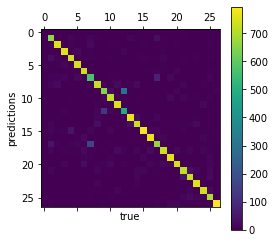

In [36]:
acc, true, pred = test_network(model_early_stopping, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_early_stopping.classes), pred, true)

## Computational Experiment 2 - Architecture

### 2a) Double Convolutional Layer

In [37]:
def display_kernels(conv_weights):
    num_kernels = conv_weights.shape[0]
    # "unnecessary code" to get square-like dimensions to align different kernels
    cols = num_kernels // int(num_kernels ** 0.5)
    rows = num_kernels // cols
    
    _, axes = plt.subplots(rows, cols, figsize=(9,9))
    kernel = 0
    for i in range(rows):
        for j in range(cols):
            axes[i,j].matshow(conv_weights[kernel][0], cmap='gray')
            kernel += 1
            title = 'Kernel ' + str(kernel)
            axes[i,j].set_title(title)
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()

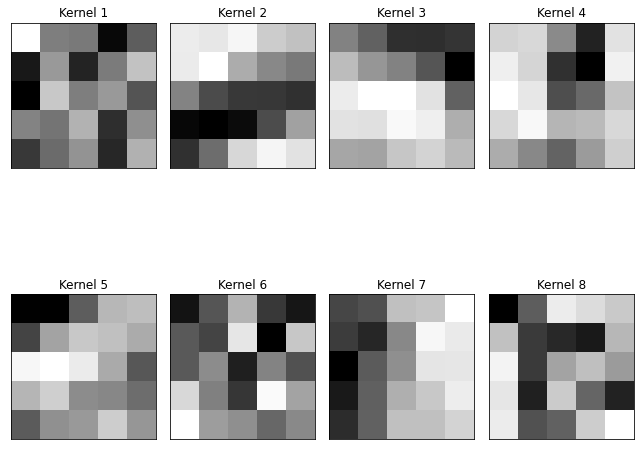

In [39]:
# extract the weights from the learned model
conv1wt = basic_model_combined.layers[0].weight.data.numpy()
display_kernels(conv1wt)

In [40]:
class letterCNNDouble(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [41]:
model_double_layer = letterCNNDouble(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_double_layer.parameters(), lr=1e-3)
train_network(model_double_layer, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.84097
   Val loss: 0.53678

EPOCH 1
 Train loss: 0.38269
   Val loss: 0.47076

EPOCH 2
 Train loss: 0.29375
   Val loss: 0.43595

EPOCH 3
 Train loss: 0.24922
   Val loss: 0.38050

EPOCH 4
 Train loss: 0.21849
   Val loss: 0.40586

EPOCH 5
 Train loss: 0.19468
   Val loss: 0.38329

EPOCH 6
 Train loss: 0.17645
   Val loss: 0.39143

EPOCH 7
 Train loss: 0.16138
   Val loss: 0.38599

EPOCH 8
 Train loss: 0.14661
   Val loss: 0.39926

EPOCH 9
 Train loss: 0.13554
   Val loss: 0.40829



Test accuracy: 90.741


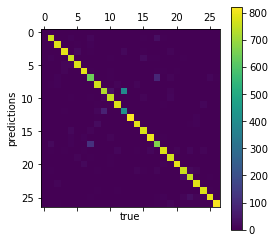

In [42]:
acc, true, pred = test_network(model_double_layer, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_double_layer.classes), pred, true)

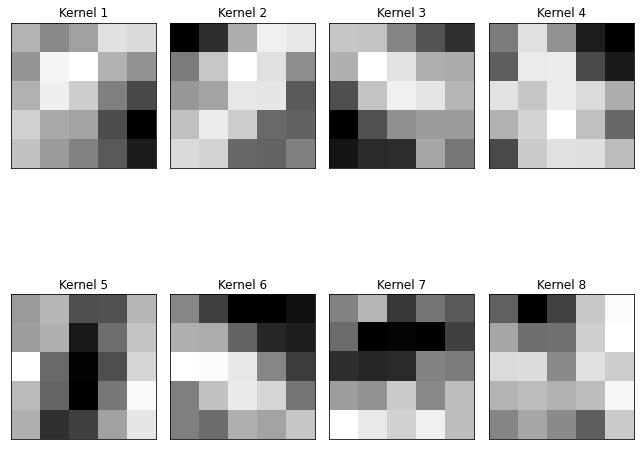

In [43]:
# extract the weights from the learned model
conv2wtsfirst = model_double_layer.layers[0].weight.data.numpy()
display_kernels(conv2wtsfirst)

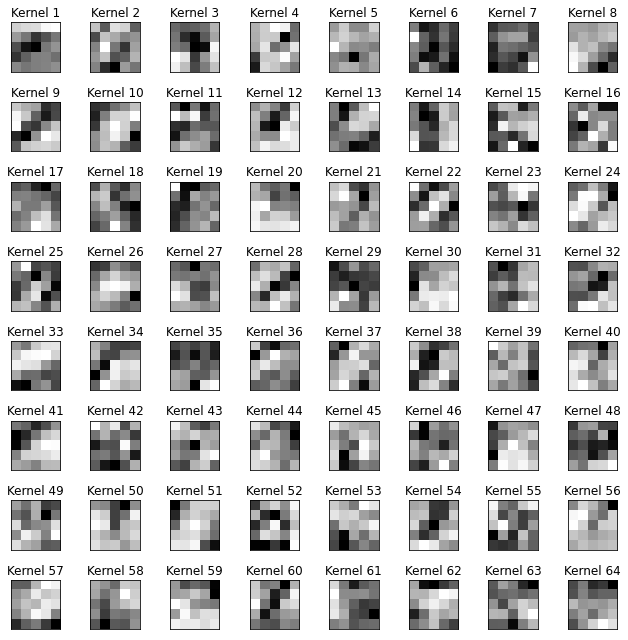

In [44]:
# extract the weights from the learned model
conv2wtssecond = model_double_layer.layers[3].weight.data.numpy()
display_kernels(conv2wtssecond)

### 2b) Changing the Kernel Size

In [45]:
class letterCNNKernel(nn.Module):
    def __init__(self, classes, size):
        super().__init__()
        self.classes = classes
        output_size = (((28 - size) + 1) // 2) ** 2 * 8 
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(size,size), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(output_size, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

#### Size 3 kernel

In [46]:
model_kernel_3 = letterCNNKernel(classes, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_3.parameters(), lr=1e-3)
train_network(model_kernel_3, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.26756
   Val loss: 1.01389

EPOCH 1
 Train loss: 0.76398
   Val loss: 0.78053

EPOCH 2
 Train loss: 0.58966
   Val loss: 0.69749

EPOCH 3
 Train loss: 0.50281
   Val loss: 0.65394

EPOCH 4
 Train loss: 0.44949
   Val loss: 0.65273

EPOCH 5
 Train loss: 0.41500
   Val loss: 0.64909

EPOCH 6
 Train loss: 0.38895
   Val loss: 0.62806

EPOCH 7
 Train loss: 0.37144
   Val loss: 0.62221

EPOCH 8
 Train loss: 0.35522
   Val loss: 0.63128

EPOCH 9
 Train loss: 0.34271
   Val loss: 0.63524



Test accuracy: 85.088


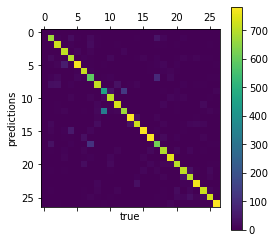

In [47]:
acc, true, pred = test_network(model_kernel_3, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_3.classes), pred, true)

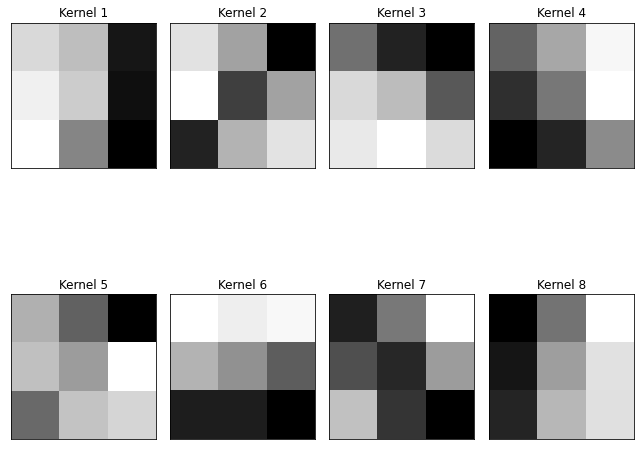

In [48]:
# extract the weights from the learned model
convk3wts = model_kernel_3.layers[0].weight.data.numpy()
display_kernels(convk3wts)

#### Size 8 kernel

In [49]:
model_kernel_8 = letterCNNKernel(classes, 8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_8.parameters(), lr=1e-3)
train_network(model_kernel_8, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.08759
   Val loss: 0.76200

EPOCH 1
 Train loss: 0.55149
   Val loss: 0.61114

EPOCH 2
 Train loss: 0.45093
   Val loss: 0.57187

EPOCH 3
 Train loss: 0.40330
   Val loss: 0.57247

EPOCH 4
 Train loss: 0.37205
   Val loss: 0.54554

EPOCH 5
 Train loss: 0.34778
   Val loss: 0.57866

EPOCH 6
 Train loss: 0.32944
   Val loss: 0.56796

EPOCH 7
 Train loss: 0.31557
   Val loss: 0.55356

EPOCH 8
 Train loss: 0.30350
   Val loss: 0.57014

EPOCH 9
 Train loss: 0.29230
   Val loss: 0.57892



Test accuracy: 86.937


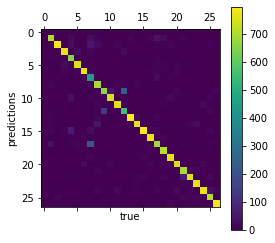

In [50]:
acc, true, pred = test_network(model_kernel_8, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_8.classes), pred, true)

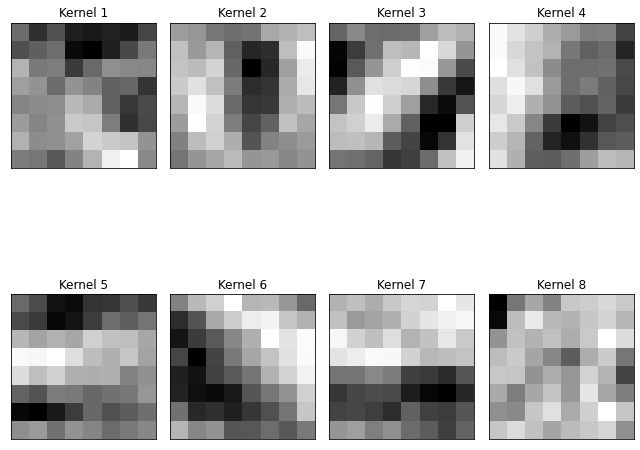

In [51]:
# extract the weights from the learned model
convk8wts = model_kernel_8.layers[0].weight.data.numpy()
display_kernels(convk8wts)

#### Size 11 kernel

In [52]:
model_kernel_11 = letterCNNKernel(classes, 11)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_11.parameters(), lr=1e-3)
train_network(model_kernel_11, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.09465
   Val loss: 0.78244

EPOCH 1
 Train loss: 0.58213
   Val loss: 0.64321

EPOCH 2
 Train loss: 0.48357
   Val loss: 0.60450

EPOCH 3
 Train loss: 0.42837
   Val loss: 0.59527

EPOCH 4
 Train loss: 0.39192
   Val loss: 0.56762

EPOCH 5
 Train loss: 0.36528
   Val loss: 0.55360

EPOCH 6
 Train loss: 0.34799
   Val loss: 0.56122

EPOCH 7
 Train loss: 0.33093
   Val loss: 0.54861

EPOCH 8
 Train loss: 0.31737
   Val loss: 0.55724

EPOCH 9
 Train loss: 0.30679
   Val loss: 0.58168



Test accuracy: 86.515


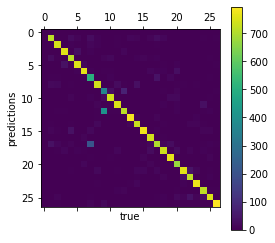

In [53]:
acc, true, pred = test_network(model_kernel_11, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_11.classes), pred, true)

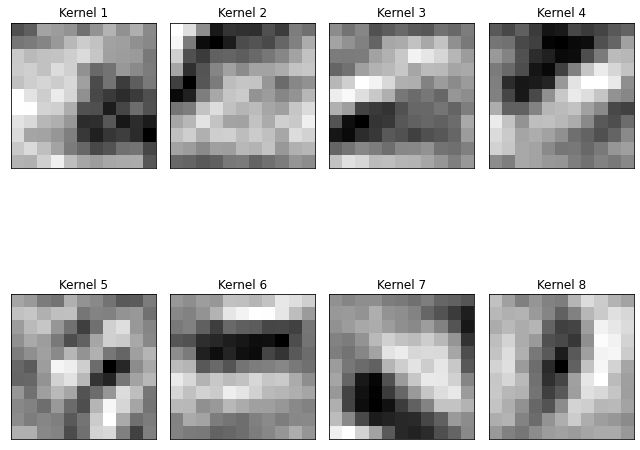

In [54]:
# extract the weights from the learned model
convk11wts = model_kernel_11.layers[0].weight.data.numpy()
display_kernels(convk11wts)

## Optimized Inputs

In [55]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [56]:
# Given model, get optimized input for each character
def get_optimized_inputs(model, nepochs = 10000, validate_loss=False):
    targets = torch.arange(len(model.classes)).long()
    optimized_inputs = {}

    for t in targets:
        # train input
        input_model = OptimizeInput(model)
        optimizer = torch.optim.Adam(input_model.parameters(), lr=.01)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(nepochs):
            optimizer.zero_grad()
            outputs = input_model()
            loss = criterion(outputs, t.reshape(1))
            loss.backward()
            optimizer.step()
        optimized_inputs[model.classes[t]] = input_model.optimized_input.detach().numpy().reshape((28, 28))
        
        # test input
        if (validate_loss):
            print("finished %s with %0.5f loss" % (model.classes[t], loss.item()), end = "\t")
            tensor = torch.Tensor(optimized_inputs[model.classes[t]].reshape(1, 1, 28, 28))
            with torch.no_grad():
                output = model(tensor)
            prob = output.squeeze().detach().numpy()
            pred = model.classes[torch.argmax(output, dim=1)]
            print(f"Expected: {model.classes[t]}. Predicted: {pred}.")
    return optimized_inputs

def display_optimized_inputs(optimized_inputs):
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    fig, axes = plt.subplots(4, 7, figsize=(9,9))
    letter = 0
    for i in range(4):
        for j in range(7):
            img = optimized_inputs[letters[letter]]
            axes[i,j].matshow(img, cmap='gray')
            title = 'opt ' + str(letters[letter])
            letter += 1
            axes[i,j].set_title(title)
            if letter > 25: break
    fig.delaxes(axes[3,5])
    fig.delaxes(axes[3,6])
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()    

In [ ]:
optimized_inputs_kernel_3 = get_optimized_inputs(model_kernel_3, nepochs=1000)
optimized_inputs_kernel_5 = get_optimized_inputs(basic_model_combined, nepochs=1000)
optimized_inputs_kernel_8 = get_optimized_inputs(model_kernel_8, nepochs=1000)
optimized_inputs_kernel_11 = get_optimized_inputs(model_kernel_11, nepochs=1000)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_3)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_5)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_8)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_11)